Saving figure at /home/lala/Documents/GitHub/smpl_to_joint/pic/image_0.png.
Processing complete.


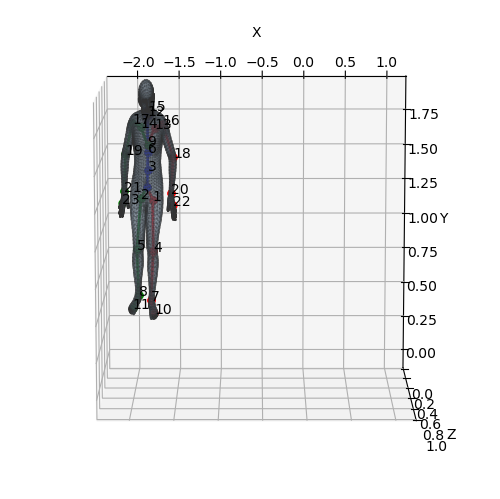

In [8]:
import numpy as np
import torch
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from display_utils import display_model  # Ensure this utility is available and correct
import random

# Set whether to use CUDA
cuda = torch.cuda.is_available()

# Load SMPL Layer
smpl_layer = SMPL_Layer(center_idx=0, gender='neutral', model_root='smplpytorch/native/models')
if cuda:
    smpl_layer = smpl_layer.cuda()

# Load motion data
motion = np.load(r'/media/lala/Elements/motionx/motion_data/smplx_322/idea400/subset_0003/Air_Quotes._During_Walking.npy')
motion = torch.tensor(motion).float()

# Organize motion parameters
motion_parms = {
    'root_orient': motion[:, :3],  # global root orientation
    'pose_body': motion[:, 3:3+63],  # body pose
    'pose_hand': motion[:, 66:66+90],  # finger articulation
    'pose_jaw': motion[:, 66+90:66+93],  # jaw pose
    'face_expr': motion[:, 159:159+50],  # face expression
    'face_shape': motion[:, 209:209+100],  # face shape
    'trans': motion[:, 309:309+3],  # global body position
    'betas': motion[:, 312:],  # body shape (static)
}

# Add zeros for missing pose elements if necessary
zeros = torch.zeros(motion_parms['pose_body'].size(0), 6)
motion_parms['pose_body'] = torch.cat((motion_parms['pose_body'], zeros), dim=1)

# Process each frame
for frame_index in range(motion_parms['root_orient'].shape[0]):
    global_orient = motion_parms['root_orient'][frame_index]
    body_shape = motion_parms['betas'][frame_index]
    body_pose = motion_parms['pose_body'][frame_index]
    translation = motion_parms['trans'][frame_index]
    
    # Prepare pose and shape parameters
    pose_params = torch.cat([global_orient.view(1, -1), body_pose.view(1, -1)], dim=1)
    shape_params = body_shape.view(1, -1)
    
    if cuda:
        pose_params = pose_params.cuda()
        shape_params = shape_params.cuda()
        translation = translation.cuda()
    
    # Get vertices and joints
    verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)
    
    # Add translation to vertices and joints
    verts += translation.view(1, 1, -1)
    Jtr += translation.view(1, 1, -1)
    
    # Convert to CPU and detach for visualization
    verts_cpu = verts.cpu().detach()
    Jtr_cpu = Jtr.cpu().detach()
    
    # Display and save the model
    display_model(
        {'verts': verts_cpu, 'joints': Jtr_cpu},
        model_faces=smpl_layer.th_faces,
        with_joints=True,
        kintree_table=smpl_layer.kintree_table,
        savepath=f'/home/lala/Documents/GitHub/smpl_to_joint/pic/image_{frame_index}.png',
        show=False
    )
    
    #IMU simulation
    break

print("Processing complete.")
